In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt

import lightgbm as lgbm
import gc
import xgboost as xgb
import pickle as pickle


from catboost import CatBoostRegressor
import dask.dataframe as dd
from sklearn.model_selection import KFold
from itertools import product

In [22]:
items           = pd.read_csv('items.csv',usecols=["item_id", "item_category_id"])
item_categories = pd.read_csv('item_categories.csv')
shops           = pd.read_csv('shops.csv')
sales_train     = pd.read_csv('sales_train.csv.gz')
test            = pd.read_csv('test.csv.gz')

In [4]:
sales_train[['day','month', 'year']] = sales_train['date'].str.split('.', expand=True).astype(int)
sales_train = sales_train[sales_train['year'].isin([2013,2014]) == False]
sales_train = sales_train.set_index('item_id').join(items.set_index('item_id'))
sales_train.reset_index(inplace=True)

In [5]:
# Якутск Орджоникидзе, 56
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [6]:
max_sales=1000
sums = sales_train.groupby('item_id')['item_cnt_day'].sum().reset_index().rename(columns={"item_cnt_day":"item_total_sales"}).sort_values(by='item_total_sales')

ids_reject = sums[(sums['item_total_sales'] > 0) & (sums['item_total_sales'] < max_sales)]['item_id'].unique()

In [7]:
train_item_ids = sales_train['item_id'].unique()
train_item_ids = np.setdiff1d(train_item_ids, ids_reject)
train_shop_ids = sales_train['shop_id'].unique()
test_item_ids = test['item_id'].unique()
test_shop_ids = test['shop_id'].unique()
train_blocks = sales_train['date_block_num'].unique()

all_item_ids = np.unique(np.append(test_item_ids,train_item_ids))
all_shop_ids = np.unique(np.append(train_shop_ids,test_shop_ids))

In [8]:
combinations = []

for dbn in range(np.min(train_blocks), np.max(train_blocks)+1):
    sales = sales_train[sales_train.date_block_num==dbn]
    item_ids = np.intersect1d(sales.item_id.unique(), test_item_ids)
    dbn_combos = list(product(sales.shop_id.unique(), item_ids, [dbn]))
    for combo in dbn_combos:
        combinations.append(combo)
        
all_combos = pd.DataFrame(np.unique(np.vstack([combinations]), axis=0), columns=['shop_id','item_id','date_block_num'])

In [9]:
ys = sales_train.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"item_cnt_block"})

training = all_combos.merge(ys, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)


training['item_cnt_block'] = training['item_cnt_block'].clip(0,20).astype('int8')

training = training.set_index('item_id').join(items.set_index('item_id'))
training.reset_index(inplace=True)

for col in ['item_id', 'shop_id', 'item_category_id']:
    training[col] = pd.to_numeric(training[col], downcast='unsigned')

In [10]:
dates = sales_train[['date_block_num', 'month', 'year']].drop_duplicates(['date_block_num', 'month', 'year'])

dates_dict = {}

for index,row in dates.iterrows():
    dates_dict[row['date_block_num']] = {"month": row['month'], "year": row['year']}
    
training['month'] = pd.to_numeric(training['date_block_num'].apply(lambda block: dates_dict[block]['month']), downcast='unsigned')


In [11]:
training["shop_cat"] = training["shop_id"].astype(str) + "_" + training["item_category_id"].astype(str)
training["shop_item"] = training["shop_id"].astype(str) + "_" + training["item_id"].astype(str)

In [12]:
unique_shop_cats = training['shop_cat'].unique()
shop_cats = dict(list(zip(unique_shop_cats, range(1,len(unique_shop_cats)))))

def get_shop_cat_int(x):
    if x in shop_cats:
        return shop_cats[x]

training['shop_cat_int'] = training['shop_cat'].apply(lambda x: get_shop_cat_int(x))

In [13]:
unique_shop_items = training['shop_item'].unique()
shop_items = dict(list(zip(unique_shop_items, range(1,len(unique_shop_items)))))

def get_shop_item_int(x):
    if x in shop_items:
        return shop_items[x]

training['shop_item_int'] = training['shop_item'].apply(lambda x: get_shop_item_int(x))

In [14]:
#https://maxhalford.github.io/blog/target-encoding-done-the-right-way/
#https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study

from sklearn.model_selection import StratifiedKFold
columns = ["item_id", "shop_id", "item_category_id", "month", "shop_cat", "shop_item", "date_block_num"]



y_train = training["item_cnt_block"].values
folds = KFold(n_splits = 5, shuffle=True).split(training)

i=1
for in_fold_index, out_of_fold_index in folds:
    print("fold", i)
    #print(np.intersect1d(training.loc[in_fold_index]["shop_id"].unique(), training.loc[out_of_fold_index]["shop_id"].unique()))
    #print(len(in_fold_index))
    for column in columns:
        means = training.iloc[in_fold_index].groupby(column)['item_cnt_block'].mean()
            #x_validation[column + "_mean_target"] = means\
        name = column + '_mean_encoding'
        training.loc[out_of_fold_index,name] = training.loc[out_of_fold_index][column].map(means)
    i+=1

fold 1
fold 2
fold 3
fold 4
fold 5


In [15]:
def add_block_units_stats(df, cols, name):
    print(name)
    name_units = name + '_units'
    name_mean = name + '_mean'
    name_median = name + '_median'
    name_max = name + '_max'
    name_min = name + '_min'
    name_std = name + '_std'
    
    
    try:
        df.drop(columns=[name_units, name_mean, name_median],inplace=True)
    except:
        pass

    
    block_units = df.groupby(cols,as_index=False)['item_cnt_block'].sum()\
                        .drop_duplicates(cols)\
                        .rename(columns={'item_cnt_block':name_units})
    df = df.merge(block_units, on=cols, how='left')
    df[name_units].fillna(0,inplace=True)
    df[name_units] = pd.to_numeric(df[name_units].astype(int),downcast='unsigned')
    del block_units
    
    block_units_med = df.groupby(cols,as_index=False)['item_cnt_block'].median()\
                        .drop_duplicates(cols)\
                        .rename(columns={'item_cnt_block':name_median})
    df = df.merge(block_units_med, on=cols, how='left')
    df[name_median].fillna(0,inplace=True)
    df[name_median] = pd.to_numeric(df[name_median].astype(int),downcast='unsigned')
    del block_units_med
    
    block_means = df.groupby(cols,as_index=False)['item_cnt_block'].mean()\
                        .drop_duplicates(cols)\
                        .rename(columns={'item_cnt_block':name_mean})
    df = df.merge(block_means, on=cols, how='left')
    df[name_mean].fillna(0,inplace=True)
    df[name_mean] = pd.to_numeric(df[name_mean],downcast='float')
    del block_means
    
    block_max = df.groupby(cols,as_index=False)['item_cnt_block'].max()\
                        .drop_duplicates(cols)\
                        .rename(columns={'item_cnt_block':name_max})
    df = df.merge(block_max, on=cols, how='left')
    df[name_max].fillna(0,inplace=True)
    df[name_max] = pd.to_numeric(df[name_max],downcast='float')
    del block_max
    
    block_min = df.groupby(cols,as_index=False)['item_cnt_block'].min()\
                        .drop_duplicates(cols)\
                        .rename(columns={'item_cnt_block':name_min})
    df = df.merge(block_min, on=cols, how='left')
    df[name_min].fillna(0,inplace=True)
    df[name_min] = pd.to_numeric(df[name_min],downcast='float')
    del block_min
    
    block_std = df.groupby(cols,as_index=False)['item_cnt_block'].std()\
                        .drop_duplicates(cols)\
                        .rename(columns={'item_cnt_block':name_std})
    df = df.merge(block_std, on=cols, how='left')
    df[name_std].fillna(0,inplace=True)
    df[name_std] = pd.to_numeric(df[name_std],downcast='float')
    del block_std
    
    gc.collect()
    return df


training = add_block_units_stats(training, ['item_id','date_block_num'], 'item_block')
training = add_block_units_stats(training, ['shop_id','date_block_num'], 'shop_block')
training = add_block_units_stats(training, ['item_category_id','date_block_num'], 'cat_block')
training = add_block_units_stats(training, ['shop_id', 'item_category_id','date_block_num'], 'shop_cat_block')
training = add_block_units_stats(training, ['shop_id', 'item_id','date_block_num'], 'shop_item_block')

item_block


/opt/conda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:970: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


shop_block
cat_block
shop_cat_block
shop_item_block


In [16]:
def add_rolls(df, cols, name, rolls = [3]):
    for roll in rolls:
        print(name, roll)
        roll_name = name+"_rolling_" + str(roll)
        roll_name_tmp = roll_name + "_tmp"
        
        try:
            df.drop(columns=[roll_name],inplace=True)
        except:
            pass       

    
        block_units_rolling_temp = df\
            .drop_duplicates(cols)\
            .sort_values(cols)\
            .set_index(cols)\
            .groupby(cols[0:len(cols)-1],as_index=False)\
            [name].rolling(roll,min_periods=2).mean().reset_index()\
            .rename(columns={name:roll_name_tmp})\
            [cols+[roll_name_tmp]]
        
    
        df = df.merge(block_units_rolling_temp, on=cols, how='left')
        #print(df.columns.values)
        del block_units_rolling_temp
        gc.collect()
        

        block_units_rolling = df\
            .drop_duplicates(cols)\
            .sort_values(cols)\
            .set_index(cols)\
            .groupby(cols[0:len(cols)-1],as_index=False)\
            [roll_name_tmp].shift(1)\
            .rename(columns={roll_name_tmp:roll_name}).reset_index()

        df = df.merge(block_units_rolling, on=cols, how='left')
        df[roll_name].fillna(0,inplace=True)
        df[roll_name] = pd.to_numeric(df[roll_name], downcast='float')
        df.drop(columns=[roll_name_tmp], inplace=True)
        del block_units_rolling
        gc.collect()
    
    return df
    

training = add_rolls(training, ['item_id','date_block_num'], 'item_block_units')
training = add_rolls(training, ['item_id','date_block_num'], 'item_block_mean')
training = add_rolls(training, ['item_id','date_block_num'], 'item_block_median')
training = add_rolls(training, ['item_id','date_block_num'], 'item_block_min')
training = add_rolls(training, ['item_id','date_block_num'], 'item_block_max')
training = add_rolls(training, ['item_id','date_block_num'], 'item_block_std')

training = add_rolls(training, ['shop_id','date_block_num'], 'shop_block_units')
training = add_rolls(training, ['shop_id','date_block_num'], 'shop_block_mean')
training = add_rolls(training, ['shop_id','date_block_num'], 'shop_block_median')
training = add_rolls(training, ['shop_id','date_block_num'], 'shop_block_min')
training = add_rolls(training, ['shop_id','date_block_num'], 'shop_block_max')
training = add_rolls(training, ['shop_id','date_block_num'], 'shop_block_std')

training = add_rolls(training, ['item_category_id','date_block_num'], 'cat_block_units')
training = add_rolls(training, ['item_category_id','date_block_num'], 'cat_block_mean')
training = add_rolls(training, ['item_category_id','date_block_num'], 'cat_block_median')
training = add_rolls(training, ['item_category_id','date_block_num'], 'cat_block_min')
training = add_rolls(training, ['item_category_id','date_block_num'], 'cat_block_max')
training = add_rolls(training, ['item_category_id','date_block_num'], 'cat_block_std')

training = add_rolls(training, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_units')
training = add_rolls(training, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_mean')
training = add_rolls(training, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_median')
training = add_rolls(training, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_min')
training = add_rolls(training, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_max')
training = add_rolls(training, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_std')
#training = add_rolls(training, ['shop_id','item_id','date_block_num'], 'shop_item')

item_block_units 3
item_block_mean 3
item_block_median 3
item_block_min 3
item_block_max 3
item_block_std 3
shop_block_units 3
shop_block_mean 3
shop_block_median 3
shop_block_min 3
shop_block_max 3
shop_block_std 3
cat_block_units 3
cat_block_mean 3
cat_block_median 3
cat_block_min 3
cat_block_max 3
cat_block_std 3
shop_cat_block_units 3
shop_cat_block_mean 3
shop_cat_block_median 3
shop_cat_block_min 3
shop_cat_block_max 3
shop_cat_block_std 3


In [17]:
#training = add_rolls(training, ['shop_id','item_id','date_block_num'], 'shop_item_block_mean')

In [18]:
training['block_total'] = training.groupby(['date_block_num'])['item_cnt_block'].transform(np.sum)

training['item_share_block'] = training['item_block_units'] * 100 / training['block_total']
training['shop_share_block'] = training['shop_block_units'] * 100 / training['block_total']
training['comp2'] = training['item_share_block'] * training['shop_share_block']

In [19]:
def add_lags(df, cols, name, lags = [1]):
    
    for lag in lags:
        print(name, lag)
        lag_name = name + "_lag_" + str(lag)
        
        try:
            df.drop(columns=[lag_name],inplace=True)
        except:
            pass       

        result = df\
            .drop_duplicates(cols)\
            .sort_values(cols)\
            .set_index(cols)\
            .groupby(cols[0:len(cols)-1],as_index=False)\
            [name].shift(lag)\
            .rename(columns={name:lag_name}).reset_index()

        df = df.merge(result, on=cols, how='left')
        df[lag_name].fillna(0,inplace=True)
        if "mean" in name or "std" in name:
            df[lag_name] = pd.to_numeric(df[lag_name], downcast='float')
        else:
            df[lag_name] = pd.to_numeric(df[lag_name].astype(int), downcast='unsigned')
        del result
        gc.collect()
    
    return df
                                         

                                        
training = add_lags(training, ['item_id','date_block_num'], 'item_block_units')
training = add_lags(training, ['item_id','date_block_num'], 'item_block_mean')
training = add_lags(training, ['item_id','date_block_num'], 'item_block_median')                                        
training = add_lags(training, ['item_id','date_block_num'], 'item_block_min')
training = add_lags(training, ['item_id','date_block_num'], 'item_block_max')
training = add_lags(training, ['item_id','date_block_num'], 'item_block_std')

training = add_lags(training, ['shop_id','date_block_num'], 'shop_block_units')
training = add_lags(training, ['shop_id','date_block_num'], 'shop_block_mean')
training = add_lags(training, ['shop_id','date_block_num'], 'shop_block_median')
training = add_lags(training, ['shop_id','date_block_num'], 'shop_block_min')
training = add_lags(training, ['shop_id','date_block_num'], 'shop_block_max')
training = add_lags(training, ['shop_id','date_block_num'], 'shop_block_std')

training = add_lags(training, ['item_category_id','date_block_num'], 'cat_block_units')
training = add_lags(training, ['item_category_id','date_block_num'], 'cat_block_mean')
training = add_lags(training, ['item_category_id','date_block_num'], 'cat_block_median')
training = add_lags(training, ['item_category_id','date_block_num'], 'cat_block_min')
training = add_lags(training, ['item_category_id','date_block_num'], 'cat_block_max')
training = add_lags(training, ['item_category_id','date_block_num'], 'cat_block_std')

training = add_lags(training, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_units')
training = add_lags(training, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_mean')
training = add_lags(training, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_median')
training = add_lags(training, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_min')
training = add_lags(training, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_max')
training = add_lags(training, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_std')

training = add_lags(training, ['shop_id','item_id','date_block_num'], 'shop_item_block_units')
training = add_lags(training, ['shop_id','item_id','date_block_num'], 'shop_item_block_mean')
training = add_lags(training, ['shop_id','item_id','date_block_num'], 'shop_item_block_median')
training = add_lags(training, ['shop_id','item_id','date_block_num'], 'shop_item_block_min')
training = add_lags(training, ['shop_id','item_id','date_block_num'], 'shop_item_block_max')
training = add_lags(training, ['shop_id','item_id','date_block_num'], 'shop_item_block_std')

item_block_units 1
item_block_mean 1
item_block_median 1
item_block_min 1
item_block_max 1
item_block_std 1
shop_block_units 1
shop_block_mean 1
shop_block_median 1
shop_block_min 1
shop_block_max 1
shop_block_std 1
cat_block_units 1
cat_block_mean 1
cat_block_median 1
cat_block_min 1
cat_block_max 1
cat_block_std 1
shop_cat_block_units 1
shop_cat_block_mean 1
shop_cat_block_median 1
shop_cat_block_min 1
shop_cat_block_max 1
shop_cat_block_std 1
shop_item_block_units 1
shop_item_block_mean 1
shop_item_block_median 1
shop_item_block_min 1
shop_item_block_max 1
shop_item_block_std 1


In [20]:
training = add_lags(training, ['item_id','date_block_num'], 'item_share_block')
training = add_lags(training, ['shop_id','date_block_num'], 'shop_share_block')
training = add_lags(training, ['shop_id', 'item_id', 'date_block_num'], 'comp2')


item_share_block 1
shop_share_block 1
comp2 1


In [21]:
total_sum_shops = training.groupby('shop_id')['item_cnt_block'].sum().sum()
training['shop_share'] = training.groupby('shop_id')['item_cnt_block'].transform(np.sum) *100 / total_sum_shops

total_sum_items = training.groupby('item_id')['item_cnt_block'].sum().sum()
training['item_share'] = training.groupby('item_id')['item_cnt_block'].transform(np.sum) *100 / total_sum_items

In [22]:
training['comp1'] = training['shop_share'] * training['item_share']

In [85]:
a = training[training['shop_id'] == 41].groupby(['shop_id', 'date_block_num'],as_index=False)['item_cnt_block'].sum()
a

,shop_id,date_block_num,item_cnt_block
0,41,24,974.0
1,41,25,687.0
2,41,26,670.0
3,41,27,528.0
4,41,28,726.0
5,41,29,583.0
6,41,30,655.0
7,41,31,834.0
8,41,32,629.0
9,41,33,722.0


In [137]:
x = a['item_cnt_block'].values.reshape(10,1)
RobustScaler().fit_transform(x)

array([[ 3.30167598],
       [ 0.09497207],
       [-0.09497207],
       [-1.68156425],
       [ 0.53072626],
       [-1.06703911],
       [-0.26256983],
       [ 1.73743017],
       [-0.55307263],
       [ 0.48603352]])

Coefficients: 
 [[-0.02182722]]
Mean squared error: 798.93
Variance score: -95.84


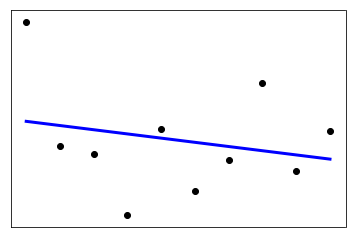

In [148]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler


a = training[training['shop_id'] == 41].groupby(['shop_id', 'date_block_num'],as_index=False)['item_cnt_block'].sum()


regr = linear_model.Ridge(alpha=0.5)

X = a['date_block_num'].values.reshape(10,1)
y = a['item_cnt_block'].values.reshape(10,1)
y = MinMaxScaler().fit_transform(y)
#y = StandardScaler().fit_transform([y])

# Train the model using the training sets
regr.fit(X, y)

# Make predictions using the testing set
preds = regr.predict(X)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(X, preds))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(X, preds))

# Plot outputs
plt.scatter(X, y,  color='black')
plt.plot(X, preds, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [147]:
regr.predict(34)

array([[ 0.26666667]])

In [23]:

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
training.sample(10)

,item_id,shop_id,date_block_num,item_cnt_block,item_category_id,month,shop_cat,shop_item,shop_cat_int,shop_item_int,item_id_mean_encoding,shop_id_mean_encoding,item_category_id_mean_encoding,month_mean_encoding,shop_cat_mean_encoding,shop_item_mean_encoding,date_block_num_mean_encoding,item_block_units,item_block_median,item_block_mean,item_block_max,item_block_min,item_block_std,shop_block_units,shop_block_median,shop_block_mean,shop_block_max,shop_block_min,shop_block_std,cat_block_units,cat_block_median,cat_block_mean,cat_block_max,cat_block_min,cat_block_std,shop_cat_block_units,shop_cat_block_median,shop_cat_block_mean,shop_cat_block_max,shop_cat_block_min,shop_cat_block_std,shop_item_block_units,shop_item_block_median,shop_item_block_mean,shop_item_block_max,shop_item_block_min,shop_item_block_std,item_block_units_rolling_3,item_block_mean_rolling_3,item_block_median_rolling_3,item_block_min_rolling_3,item_block_max_rolling_3,item_block_std_rolling_3,shop_block_units_rolling_3,shop_block_mean_rolling_3,shop_block_median_rolling_3,shop_block_min_rolling_3,shop_block_max_rolling_3,shop_block_std_rolling_3,cat_block_units_rolling_3,cat_block_mean_rolling_3,cat_block_median_rolling_3,cat_block_min_rolling_3,cat_block_max_rolling_3,cat_block_std_rolling_3,shop_cat_block_units_rolling_3,shop_cat_block_mean_rolling_3,shop_cat_block_median_rolling_3,shop_cat_block_min_rolling_3,shop_cat_block_max_rolling_3,shop_cat_block_std_rolling_3,block_total,item_share_block,shop_share_block,comp2,item_block_units_lag_1,item_block_mean_lag_1,item_block_median_lag_1,item_block_min_lag_1,item_block_max_lag_1,item_block_std_lag_1,shop_block_units_lag_1,shop_block_mean_lag_1,shop_block_median_lag_1,shop_block_min_lag_1,shop_block_max_lag_1,shop_block_std_lag_1,cat_block_units_lag_1,cat_block_mean_lag_1,cat_block_median_lag_1,cat_block_min_lag_1,cat_block_max_lag_1,cat_block_std_lag_1,shop_cat_block_units_lag_1,shop_cat_block_mean_lag_1,shop_cat_block_median_lag_1,shop_cat_block_min_lag_1,shop_cat_block_max_lag_1,shop_cat_block_std_lag_1,shop_item_block_units_lag_1,shop_item_block_mean_lag_1,shop_item_block_median_lag_1,shop_item_block_min_lag_1,shop_item_block_max_lag_1,shop_item_block_std_lag_1,item_share_block_lag_1,shop_share_block_lag_1,comp2_lag_1,shop_share,item_share,comp1
621805,9500,41,27,0,40,4,41_40,41_9500,35.0,98492.0,0.101928,0.223111,0.358244,0.362419,0.204539,0.000000,0.362419,2,0,0.042553,1,0,0.0,528,0,0.178078,20,0,0.0,6777,0,0.369722,20,0,0.0,49,0,0.125641,4,0,0.0,0,0,0,0,0,0.0,6.666667,0.139519,0.0,0.0,2.333333,0.0,777.000000,0.279713,0.0,0.0,17.0,0.0,6585.666504,0.416115,0.0,0.0,20.000000,0.0,90.666664,0.274610,0.0,0.0,4.333333,0.0,50362.0,0.003971,1.048410,0.004163,7,0.152174,0,0,2,0.0,670,0.230399,0,0,19,0.0,6871,0.417233,0,0,20,0.0,90,0.251397,0,0,5,0.0,0,0.0,0,0,0,0.0,0,0,0,1.251248,0.008392,0.010500
501379,7524,57,26,1,55,3,57_55,57_7524,780.0,78746.0,0.227273,0.671794,0.260890,0.437983,0.414463,0.222222,0.437983,17,0,0.369565,2,0,0.0,2103,0,0.723177,20,0,0.0,7806,0,0.334705,20,0,0.0,223,0,0.439842,5,0,0.0,1,1,1,1,1,0.0,19.000000,0.392766,0.0,0.0,3.500000,0.0,2490.500000,0.912099,0.0,0.0,20.0,0.0,7381.000000,0.310212,0.0,0.0,17.500000,0.0,194.000000,0.396025,0.0,0.0,6.000000,0.0,58665.0,0.028978,0.233393,0.006763,20,0.425532,0,0,4,0.0,2313,0.840785,0,0,20,0.0,6820,0.294932,0,0,15,0.0,182,0.369919,0,0,8,0.0,0,0.0,0,0,0,0.0,0,0,0,3.819626,0.017497,0.066834
1140968,17010,16,32,0,55,9,16_55,16_17010,741.0,184662.0,0.293629,0.308716,0.260890,0.343448,0.187018,0.125000,0.343448,6,0,0.139535,2,0,0.0,858,0,0.236168,20,0,0.0,4757,0,0.192062,10,0,0.0,49,0,0.085069,2,0,0.0,0,0,0,0,0,0.0,13.333333,0.311923,0.0,0.0,2.000000,0.0,1003.333313,0.303465,0.0,0.0,20.0,0.0,5802.333496,0.247697,0.0,0.0,15.666667,0.0,98.666664,0.179644,0.0,0.0,4.000000,0.0,53347.0,0.011247,0.379853,0.004272,10,0.238095,0,0,1,0.0,1098,0.317708,0,0,20,0.0,5742,0.245448,0,0,13,0.0,91,0.163375,0,0,4,0.0,0,0.0,0,0,0,0.0,0,0,0,1.754925,0.023032,0.040420
449411,650

In [24]:
training.columns.values

array(['item_id', 'shop_id', 'date_block_num', 'item_cnt_block',
       'item_category_id', 'month', 'shop_cat', 'shop_item',
       'shop_cat_int', 'shop_item_int', 'item_id_mean_encoding',
       'shop_id_mean_encoding', 'item_category_id_mean_encoding',
       'month_mean_encoding', 'shop_cat_mean_encoding',
       'shop_item_mean_encoding', 'date_block_num_mean_encoding',
       'item_block_units', 'item_block_median', 'item_block_mean',
       'item_block_max', 'item_block_min', 'item_block_std',
       'shop_block_units', 'shop_block_median', 'shop_block_mean',
       'shop_block_max', 'shop_block_min', 'shop_block_std',
       'cat_block_units', 'cat_block_median', 'cat_block_mean',
       'cat_block_max', 'cat_block_min', 'cat_block_std',
       'shop_cat_block_units', 'shop_cat_block_median',
       'shop_cat_block_mean', 'shop_cat_block_max', 'shop_cat_block_min',
       'shop_cat_block_std', 'shop_item_block_units',
       'shop_item_block_median', 'shop_item_block_mean',
  

In [25]:
training.fillna(0,inplace=True)
training = training.sample(frac=1).reset_index(drop=True)


In [68]:
gc.collect()

ZEROS_KEEP=0.25

#x_train = training[(training['date_block_num'] < 33) & (training['val_ignore'] == False)]
x_train = training[(training['date_block_num'] < 33)]
y_train = x_train['item_cnt_block']





x_val = training[training['date_block_num'] == 33]
y_val = x_val['item_cnt_block']

pos_val_len = len(y_val[y_val != 0])
print("pos_val_len", pos_val_len)

zeros_keep_indices_val = y_val[y_val == 0].sample(int(pos_val_len/ZEROS_KEEP)).index
print("zeros_keep_indices_val", len(zeros_keep_indices_val))
non_zeros_val_indices = y_val[y_val != 0].index
print("non_zeros_val_indices", len(non_zeros_val_indices))

val_indices = np.append(np.array(zeros_keep_indices_val), np.array(non_zeros_val_indices))

y_val = y_val.loc[val_indices]
x_val = x_val.loc[val_indices]



pos_val_len 29202
zeros_keep_indices_val 116808
non_zeros_val_indices 29202


In [69]:
features = [
    
'item_id_mean_encoding',
       'shop_id_mean_encoding', #'item_category_id_mean_encoding',
#       'month_mean_encoding', 'shop_cat_mean_encoding',
#       'shop_item_mean_encoding', 'date_block_num_mean_encoding',
 
#       'item_block_units_rolling_3', 'item_block_mean_rolling_3',
#       'item_block_median_rolling_3', 'item_block_min_rolling_3',
#       'item_block_max_rolling_3', 'item_block_std_rolling_3',
    
#       'shop_block_units_rolling_3', 'shop_block_mean_rolling_3',
#       'shop_block_median_rolling_3', 'shop_block_min_rolling_3',
#       'shop_block_max_rolling_3', 'shop_block_std_rolling_3',
    
#       'cat_block_units_rolling_3', 'cat_block_mean_rolling_3',
#       'cat_block_median_rolling_3', 'cat_block_min_rolling_3',
#       'cat_block_max_rolling_3', 'cat_block_std_rolling_3',
    
       'shop_cat_block_units_rolling_3', 'shop_cat_block_mean_rolling_3',
       'shop_cat_block_median_rolling_3', 'shop_cat_block_min_rolling_3',
       'shop_cat_block_max_rolling_3', 'shop_cat_block_std_rolling_3',
    
    
#       'item_block_units_lag_1', 'item_block_mean_lag_1',
#       'item_block_median_lag_1', 'item_block_min_lag_1',
#       'item_block_max_lag_1', 'item_block_std_lag_1',
    
#       'shop_block_units_lag_1', 'shop_block_mean_lag_1',
#       'shop_block_median_lag_1', 'shop_block_min_lag_1',
       'shop_block_max_lag_1', 'shop_block_std_lag_1',
    
#      'cat_block_units_lag_1', 'cat_block_mean_lag_1',
#       'cat_block_median_lag_1', 'cat_block_min_lag_1',
#       'cat_block_max_lag_1', 'cat_block_std_lag_1',
    
       'shop_cat_block_units_lag_1', 'shop_cat_block_mean_lag_1',
#       'shop_cat_block_median_lag_1', 'shop_cat_block_min_lag_1',
#       'shop_cat_block_max_lag_1', 'shop_cat_block_std_lag_1',
    
       'shop_item_block_units_lag_1', 'shop_item_block_mean_lag_1',
#       'shop_item_block_median_lag_1', 'shop_item_block_min_lag_1',
#       'shop_item_block_max_lag_1', 'shop_item_block_std_lag_1',
    
       'item_share_block_lag_1', 'shop_share_block_lag_1', 'comp2_lag_1',

]


In [70]:
from sklearn.preprocessing import MinMaxScaler

x_train_scaled = MinMaxScaler().fit_transform(x_train[features])
x_val_scaled = MinMaxScaler().fit_transform(x_val[features])

In [71]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression,BayesianRidge, HuberRegressor


lr_model =  Ridge()
lr_model.fit(x_train_scaled, y_train)

from sklearn.metrics import mean_squared_error
from math import sqrt

lr_val_preds = lr_model.predict(x_val_scaled)
lr_val_preds.clip(0,20,out=lr_val_preds)
rms = sqrt(mean_squared_error(y_val, lr_val_preds))
print("rmse: ", rms)

rmse:  1.110650872876163


In [30]:
lr_model.coef_

array([  1.30081037e+01,   7.12896578e-01,   7.50591843e-02,
         9.89707045e-01,   3.56847427e+00,  -4.92941669e+00,
        -2.89940486e-01,   0.00000000e+00,  -3.41294595e-01,
         0.00000000e+00,   4.06768536e-01,   3.54304381e+00,
         2.58360656e+00,   2.58360656e+00,  -6.45925318e-01,
        -7.14925454e-03,  -1.43185553e+00])

In [23]:
test            = pd.read_csv('test.csv.gz')
test = test.set_index('item_id').join(items.set_index('item_id'))
test.reset_index(inplace=True)

In [48]:
item_features = [ 
    'item_id_mean_encoding'
                ]

merge_col = ['item_id']
cols=item_features+merge_col

test = test.merge(training.drop_duplicates('item_id')[cols], on=merge_col, how='left')

In [49]:
shop_features = [
        'shop_id_mean_encoding'
]

merge_col = ['shop_id']
cols=shop_features+merge_col


test = test.merge(training.drop_duplicates(merge_col)[cols], on=merge_col, how='left')

In [50]:
cat_features = [
        'item_category_id_mean_encoding'#,'cat_me_real'
]

merge_col = ['item_category_id']
cols=cat_features+merge_col


test = test.merge(training.drop_duplicates(merge_col)[cols], on=merge_col, how='left')

In [51]:
shop_item_features = [
        'shop_item_mean_encoding'
]

merge_col = ['shop_id', 'item_id']
cols=shop_item_features+merge_col


test = test.merge(training.drop_duplicates(merge_col)[cols], on=merge_col, how='left')

In [52]:
shop_cat_features = [
        'shop_cat_mean_encoding'
]

merge_col = ['shop_id', 'item_id']
cols=shop_cat_features+merge_col


test = test.merge(training.drop_duplicates(merge_col)[cols], on=merge_col, how='left')

In [53]:
def add_rolls_test(df, cols, name, rolls = [3]):
    for roll in rolls:
        print(name, roll)
        roll_name = name+"_rolling_" + str(roll)
        roll_name_tmp = roll_name + "_tmp"
        
        try:
            df.drop(columns=[roll_name],inplace=True)
        except:
            pass       

    
        block_units_rolling_temp = training\
            .drop_duplicates(cols)\
            .sort_values(cols)\
            .set_index(cols)\
            .groupby(cols[0:len(cols)-1],as_index=False)\
            [name].rolling(roll,min_periods=2).mean().reset_index()\
            .rename(columns={name:roll_name})\
            [cols+[roll_name]]
        
        print([cols[0:len(cols)-1]+[roll_name]])
        thirty_three = block_units_rolling_temp[block_units_rolling_temp['date_block_num'] == 33].drop_duplicates(cols)\
                [cols[0:len(cols)-1]+[roll_name]]
        df = df.merge(thirty_three, on=cols[0:len(cols)-1], how='left')
    

        del block_units_rolling_temp
        gc.collect()
        

    
    return df
    

test = add_rolls_test(test, ['item_id','date_block_num'], 'item_block_mean')
test = add_rolls_test(test, ['item_id','date_block_num'], 'item_block_units')
test = add_rolls_test(test, ['shop_id','date_block_num'], 'shop_block_mean')
test = add_rolls_test(test, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_mean')

test = add_rolls_test(test, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_units')
test = add_rolls_test(test, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_mean')
test = add_rolls_test(test, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_median')
test = add_rolls_test(test, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_min')
test = add_rolls_test(test, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_max')
test = add_rolls_test(test, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_std')

item_block_mean 3
[['item_id', 'item_block_mean_rolling_3']]
item_block_units 3
[['item_id', 'item_block_units_rolling_3']]
shop_block_mean 3
[['shop_id', 'shop_block_mean_rolling_3']]
shop_cat_block_mean 3
[['shop_id', 'item_category_id', 'shop_cat_block_mean_rolling_3']]
shop_cat_block_units 3
[['shop_id', 'item_category_id', 'shop_cat_block_units_rolling_3']]
shop_cat_block_mean 3
[['shop_id', 'item_category_id', 'shop_cat_block_mean_rolling_3']]
shop_cat_block_median 3
[['shop_id', 'item_category_id', 'shop_cat_block_median_rolling_3']]
shop_cat_block_min 3
[['shop_id', 'item_category_id', 'shop_cat_block_min_rolling_3']]
shop_cat_block_max 3
[['shop_id', 'item_category_id', 'shop_cat_block_max_rolling_3']]
shop_cat_block_std 3
[['shop_id', 'item_category_id', 'shop_cat_block_std_rolling_3']]


In [54]:
test = add_rolls_test(test, ['item_category_id','date_block_num'], 'cat_block_mean')

cat_block_mean 3
[['item_category_id', 'cat_block_mean_rolling_3']]


In [55]:
test = add_rolls_test(test, ['shop_id','item_id','date_block_num'], 'shop_item_block_mean')

shop_item_block_mean 3
[['shop_id', 'item_id', 'shop_item_block_mean_rolling_3']]


In [56]:
def add_lags_test(df, cols, name, lags = [1]):
    
    for lag in lags:
        print(name, lag)
        lag_name = name + "_lag_" + str(lag)
        
        try:
            df.drop(columns=[lag_name],inplace=True)
        except:
            pass       

        result = training\
            .drop_duplicates(cols)\
            .sort_values(cols)\
            .set_index(cols)\
            .groupby(cols[0:len(cols)-1],as_index=False)\
            [name].shift(lag)\
            .rename(columns={name:lag_name}).reset_index()
        
        thirty_three = result[result['date_block_num'] == 33].drop_duplicates(cols)\
                [cols[0:len(cols)-1] + [lag_name]]
        df = df.merge(thirty_three, on=cols[0:len(cols)-1], how='left')

        gc.collect()
    
    return df
                                         

                                        
test = add_lags_test(test, ['item_id','date_block_num'], 'item_block_mean')
test = add_lags_test(test, ['item_id','date_block_num'], 'item_block_units')
test = add_lags_test(test, ['shop_id','date_block_num'], 'shop_block_mean')
test = add_lags_test(test, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_mean')

test = add_lags_test(test, ['shop_id','date_block_num'], 'shop_block_max')
test = add_lags_test(test, ['shop_id','date_block_num'], 'shop_block_std')

test = add_lags_test(test, ['shop_id','item_category_id','date_block_num'], 'shop_cat_block_units')

test = add_lags_test(test, ['shop_id','item_id','date_block_num'], 'shop_item_block_units')
test = add_lags_test(test, ['shop_id','item_id','date_block_num'], 'shop_item_block_mean')

test = add_lags_test(test, ['item_id','date_block_num'], 'item_share_block')
test = add_lags_test(test, ['shop_id','date_block_num'], 'shop_share_block')
test = add_lags_test(test, ['shop_id','item_id','date_block_num'], 'comp2')

item_block_mean 1
item_block_units 1
shop_block_mean 1
shop_cat_block_mean 1
shop_block_max 1
shop_block_std 1
shop_cat_block_units 1
shop_item_block_units 1
shop_item_block_mean 1
item_share_block 1
shop_share_block 1
comp2 1


In [57]:
test = add_lags_test(test, ['shop_id','item_id','date_block_num'], 'shop_item_block_mean')
#test = add_lags_test(test, ['shop_id','item_id','date_block_num'], 'shop_item_block_units')

shop_item_block_mean 1


In [58]:
test = add_lags_test(test, ['shop_id','date_block_num'], 'shop_block_units')

shop_block_units 1


In [59]:
test.fillna(0, inplace=True)

In [60]:
from sklearn.preprocessing import MinMaxScaler

test_scaled = MinMaxScaler().fit_transform(test[features])


In [61]:
lr_preds = lr_model.predict(test_scaled)
lr_preds.clip(0,20,out=lr_preds)

array([ 0.00922014,  0.        ,  0.38453057, ...,  0.4394542 ,
        0.40602304,  0.39392012])

In [62]:
print(np.mean(lr_preds))
print(np.max(lr_preds))

0.356759730187
20.0


In [ ]:
np.mean(lg_preds.conc lr_preds, axis=1)

In [ ]:
preds = np.mean(np.array([lg_preds, lr_preds]),axis=0)

In [34]:
submission = test.loc[:,['ID']]
submission['item_cnt_month'] = preds

submission.to_csv('submission.csv', index=False)

In [33]:
lr_preds = pd.read_csv('lr112.csv')['item_cnt_month']
lg_preds = pd.read_csv('lg111.csv')['item_cnt_month']
cb_preds = pd.read_csv('cb102.csv')['item_cnt_month']


#preds = np.mean(np.array([lr_preds, lg_preds]),axis=0)

preds = (cb_preds * 0.75) + (lr_preds * 0.25)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Create a random forest classifier
clf = RandomForestRegressor(n_estimators=10, random_state=0, n_jobs=8)

# Train the classifier
clf.fit(x_train[features], y_train)

# Print the name and gini importance of each feature
for feature in zip(features, clf.feature_importances_):
    print(feature)